cpu
(240, 320, 3)


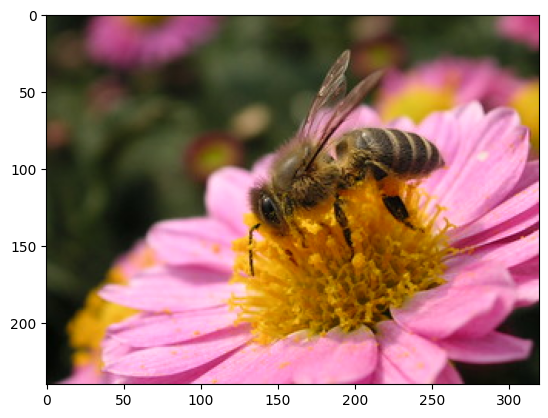

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms 
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

if (torch.cuda.is_available()):
    device = torch.device('cuda')
    print (device, torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print (device)
    
img_name = 'dataframe/1240800_e5f2b40032_n.jpg'
img0 = cv2.imread(img_name)
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
print (img0.shape)
plt.imshow(img0)
plt.show()

In [2]:
bbox0 = np.array([[24,109.0 , 171,267],[24,109.0 , 171,267]])
labels= np.array([1, 1])  


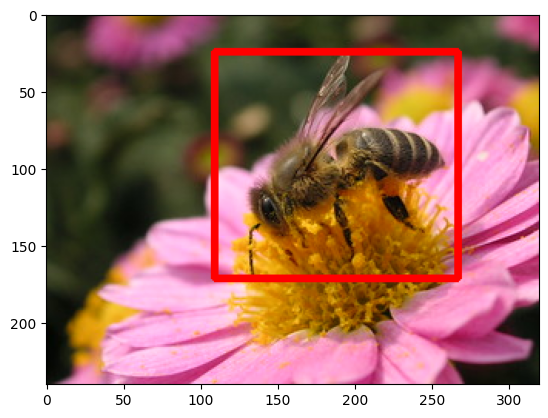

In [3]:
img_cloned = np.copy(img0)
for box in bbox0:
    cv2.rectangle(img_cloned, (int(box[1]), int(box[0])), (int(box[3]), int(box[2])), (255,0,0), 3)
plt.imshow(img_cloned)
plt.show()

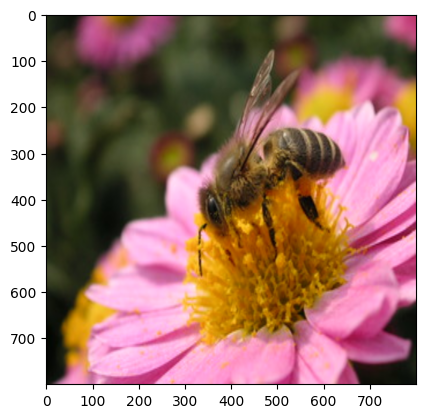

In [4]:
img = cv2.resize(img0, (800, 800))
plt.imshow(img)
plt.show()

In [5]:
Wratio = 800/img0.shape[1]
Hratio = 800/img0.shape[0]
ratioLst = [Hratio, Wratio, Hratio, Wratio]
bbox= []
for box in bbox0:
    box= [int(a * b) for a,b in zip(box, ratioLst)]
    bbox.append(box)
bbox = np.array(bbox)
print (bbox)
    

[[ 80 272 570 667]
 [ 80 272 570 667]]


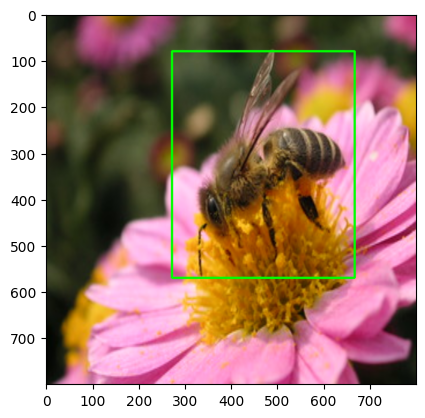

In [6]:
# display bounding box and labels
img_clone = np.copy(img)
bbox_clone = bbox.astype(int)
for i in range(len(bbox)):
        cv2.rectangle(img_clone, (bbox_clone[i][1], bbox_clone[i][0]), (bbox_clone[i][3], bbox_clone[i][2]), (0, 255, 0), 3)  # Draw Rectangle
plt.imshow(img_clone)
plt.show()


In [7]:
model = torchvision.models.vgg16(pretrained=True).to(device)
fe = list(model.features)
print (len(fe))

c:\Users\mopi7\OneDrive\Documents\BEEBOOP\.conda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mopi7\OneDrive\Documents\BEEBOOP\.conda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


31


In [8]:
dummy_img = torch.zeros((1, 3, 800, 800)).float() # test image array [1, 3, 800, 800]
print(dummy_img.shape)

req_features = []
k = dummy_img.clone().to(device)
for i in fe:
    k = i(k)
    if k.size()[2] < 800/16:  #800/16=50
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features)) #30
print(out_channels) # 512


torch.Size([1, 3, 800, 800])
30
512


In [9]:
faster_rcnn_fe_extractor = nn.Sequential(*req_features)

In [10]:
transform = transforms.Compose([transforms.ToTensor()]) # Defining PyTorch Transform
imgTensor = transform(img).to(device)
imgTensor = imgTensor.unsqueeze(0)
out_map = faster_rcnn_fe_extractor(imgTensor)
print(out_map.size())

torch.Size([1, 512, 50, 50])


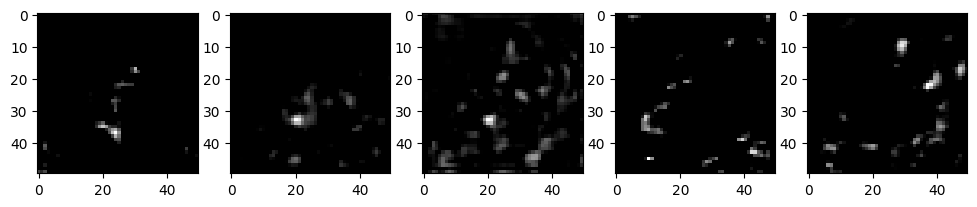

In [11]:
imgArray = out_map.data.cpu().numpy().squeeze(0)
fig = plt.figure(figsize=(12, 4))
figNo = 1
for i in range(5):
    fig.add_subplot(1, 5, figNo)
    plt.imshow(imgArray[i], cmap='gray')
    figNo += 1
plt.show()


In [12]:
# x, y intervals to generate anchor box center
fe_size = (800 // 16)
ctr_x = np.arange(16, (fe_size + 1) * 16, 16)
ctr_y = np.arange(16, (fe_size + 1) * 16, 16)
print(len(ctr_x), ctr_x)

50 [ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 272 288
 304 320 336 352 368 384 400 416 432 448 464 480 496 512 528 544 560 576
 592 608 624 640 656 672 688 704 720 736 752 768 784 800]


In [13]:
index = 0
ctr = np.zeros((2500, 2))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 8
        ctr[index, 0] = ctr_y[y] - 8
        index += 1
print(ctr.shape)

(2500, 2)


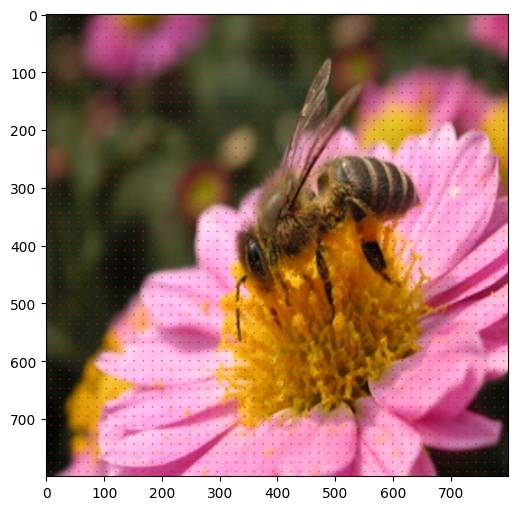

In [14]:
# display the 2500 anchors
img_clone = np.copy(img)
plt.figure(figsize=(9, 6))
for i in range(ctr.shape[0]):
    cv2.circle(img_clone, (int(ctr[i][0]), int(ctr[i][1])), radius=1, color=(255, 0, 0), thickness=1)
plt.imshow(img_clone)
plt.show()


In [15]:
# for each of the 2500 centers, generate 9 anchor boxes
# 2500*9 = 22500 anchor boxes
ratios = [0.5, 1, 2]
scales = [8, 16, 32]
sub_sample = 16
anchor_boxes = np.zeros(((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(scales)):
            h = sub_sample * scales[j] * np.sqrt(ratios[i])
            w = sub_sample * scales[j] * np.sqrt(1. / ratios[i])
            anchor_boxes[index, 0] = ctr_y - h / 2.
            anchor_boxes[index, 1] = ctr_x - w / 2.
            anchor_boxes[index, 2] = ctr_y + h / 2.
            anchor_boxes[index, 3] = ctr_x + w / 2.
            index += 1
print(anchor_boxes.shape)


(22500, 4)


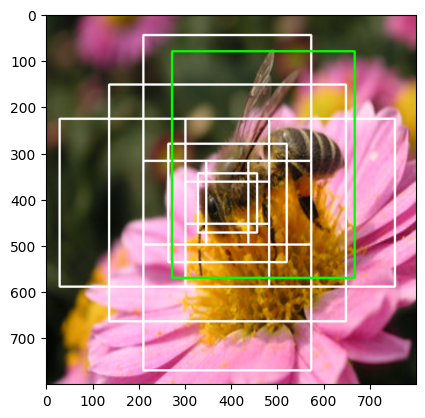

In [16]:
img_clone = np.copy(img)
for i in range(11025, 11034):  # 9*1225=11025
    x0 = int(anchor_boxes[i][1])
    y0 = int(anchor_boxes[i][0])
    x1 = int(anchor_boxes[i][3])
    y1 = int(anchor_boxes[i][2])
    cv2.rectangle(img_clone, (x0, y0), (x1, y1), color=(255, 255, 255), thickness=3)

for i in range(len(bbox)):
    cv2.rectangle(img_clone, (bbox[i][1], bbox[i][0]), (bbox[i][3], bbox[i][2]), color=(0, 255, 0), thickness=3) # Draw Rectangle

plt.imshow(img_clone)
plt.show()


In [17]:
index_inside = np.where(
    (anchor_boxes[:, 0] >= 0) &
    (anchor_boxes[:, 1] >= 0) &
    (anchor_boxes[:, 2] <= 800) &
    (anchor_boxes[:, 3] <= 800)
)[0]
print(index_inside.shape)

valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)


(8940,)
(8940, 4)


In [18]:
ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)

for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2 - yb1) * (xb2 - xb1)
        
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            inter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = inter_area / (anchor_area + box_area - inter_area)
        else:
            iou = 0.0
        
        ious[num1, num2] = iou

print(ious.shape)


(8940, 2)


In [19]:
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)

gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)


[4844 4844]
[0.73833466 0.73833466]
[4844 4844 5108 5108 5354 5354 5600 5600 5846 5846 6092 6092 6338 6338]


In [20]:
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)

max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)


(8940,)
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


In [21]:
label = np.empty((len(index_inside),), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [22]:
pos_iou_threshold  = 0.7
neg_iou_threshold = 0.3
label[gt_argmax_ious] = 1
label[max_ious >= pos_iou_threshold] = 1
label[max_ious < neg_iou_threshold] = 0

In [23]:
nsample = 256
pos_ratio = 0.5
n_pos = pos_ratio * nsample

pos_index = np.where(label == 1)[0]
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1

n_neg = nsample * np.sum(label == 1)
neg_index = np.where(label == 0)[0]
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1

In [24]:
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox.shape)

height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width

base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = max_iou_bbox[:, 0] + 0.5 * base_height
base_ctr_x = max_iou_bbox[:, 1] + 0.5 * base_width

eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs.shape)


(8940, 4)
(8940, 4)


In [25]:
anchor_labels = np.empty((len(anchor_boxes),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
print(anchor_labels.shape)

anchor_locations = np.empty((len(anchor_boxes),) + anchor_boxes.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
print(anchor_locations.shape)

(22500,)
(22500, 4)


In [ ]:
in_channels = 512
mid_channels = 512
n_anchor = 9

conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1).to(device)
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()

reg_layer = nn.Conv2d(mid_channels, n_anchor * 4, 1, 1, 0).to(device)
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()

cls_layer = nn.Conv2d(mid_channels, n_anchor * 2, 1, 1, 0).to(device)
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()